# Fitting of tunneling spectroscopy measurments
In this notebook, some pyusadel routines are used to fit NS tunneling spectroscopy data.

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
from pyusadel import UsadelProblem, fit_nsts, trivial_diffops, thermal_broadening

In [2]:
data_file_url = "resources/example_nsts_data.dat"
data = np.loadtxt(data_file_url)
e_ax_exp = data[:, 0]
dos_exp = data[:, 1]

Text(0, 0.5, '$G$ ($2e^2/\\hbar$)')

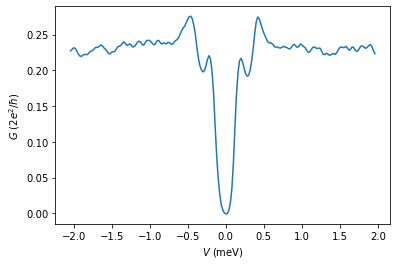

In [3]:
# Plot the data
fig, ax = plt.subplots()
ax.plot(e_ax_exp, dos_exp)
ax.set_xlabel(r"$V$ (meV)")
ax.set_ylabel(r"$G$ ($2e^2/\hbar$)")

In [4]:
# Set the initial guess and fitting bounds
N_0 = (dos_exp[0] + dos_exp[-1]) / 2

initial_guess = dict(
    N_0=N_0,
    Delta=0.30,
    h=0.1,
    tau_sf_inv=0.1,
    tau_so_inv=0.1,
    Gamma=1e-4,
    T=1e-3,
)

lower_bounds = dict(
    N_0=N_0 * 0.9,
    Delta=0,
    h=0,
    tau_sf_inv=0.0,
    tau_so_inv=0,
    Gamma=1e-6,
    T=1e-5,
)

upper_bounds = dict(
    N_0=N_0 * 1.1,
    Delta=0.350,
    h=0.350,
    tau_sf_inv=0.5,
    tau_so_inv=0.5,
    Gamma=1e-3,  # 5e-3,
    T=1e-1,
)

In [5]:
popt, pcov = fit_nsts(
    e_ax_exp,
    dos_exp,
    initial_guess=tuple(initial_guess.values()),
    bounds=(tuple(lower_bounds.values()), tuple(upper_bounds.values())),
    verbose=False,
)

In [6]:
output_str = f"""\
N_0 = {popt[0]:3.3f} ({pcov[0, 0]:3.2e}) 
Delta = {popt[1]:3.3f} ({pcov[1, 1]:3.2e})
h = {popt[2]:3.3f} ({pcov[2, 2]:3.2e})
tau_sf_inv = {popt[3]:3.3f} ({pcov[3, 3]:3.2e})
tau_so_inv = {popt[4]:3.3f} ({pcov[4, 4]:3.2e})
Gamma = {popt[5]:3.2e} ({pcov[5, 5]:3.2e})
T = {popt[6]:3.2e} ({pcov[6, 6]:3.2e})\
"""

print(output_str)

N_0 = 0.222 (6.80e-06) 
Delta = 0.331 (1.23e-03)
h = 0.074 (3.02e-03)
tau_sf_inv = 0.181 (3.19e-03)
tau_so_inv = 0.105 (3.00e-01)
Gamma = 1.00e-06 (1.70e-04)
T = 4.24e-02 (9.61e-05)


In [7]:
# Solve the problem with the fitted parameters

N_0, Delta, h, tau_sf_inv, tau_so_inv, Gamma, T = popt

up = UsadelProblem(
    Nsites=1,
    diff_ops=trivial_diffops(),
    h_x=np.array([0.0]) + h,
    h_y=np.array([0.0]),
    h_z=np.array([0.0]),
    tau_sf_inv=np.array([0.0]) + tau_sf_inv,
    tau_so_inv=np.array([0.0]) + tau_so_inv,
    D=0,
    T=T,
    Gamma=Gamma,
)

up.Delta = np.array([Delta])

up.set_real_omega_ax(-2, 2, 401)
up.solve_spectral()

DOS_fit = thermal_broadening(up.get_omega_ax_r(), N_0 * up.get_dos(), T)
DOS_fitu = thermal_broadening(
    up.get_omega_ax_r(), N_0 * up.get_spin_resolved_dos("x")[0], T
)
DOS_fitd = thermal_broadening(
    up.get_omega_ax_r(), N_0 * up.get_spin_resolved_dos("x")[1], T
)

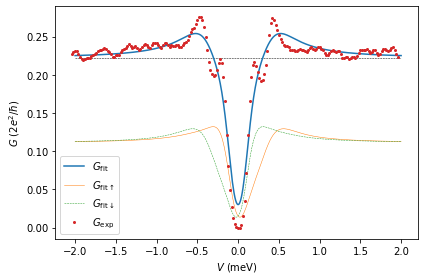

In [8]:
# Plot the fitting together with the experimental data

fig, ax = plt.subplots(figsize=(6, 4))
ax.hlines([N_0], -2, 2, "k", linestyles="--", linewidths=0.5)
ax.plot(up.get_omega_ax_r(), DOS_fit, "-", label=r"$G_\mathrm{fit}$")
ax.plot(
    up.get_omega_ax_r(),
    DOS_fitu,
    "-",
    linewidth=0.5,
    label=r"$G_{\mathrm{fit} \uparrow}$",
)
ax.plot(
    up.get_omega_ax_r(),
    DOS_fitd,
    "--",
    linewidth=0.5,
    label=r"$G_{\mathrm{fit} \downarrow}$",
)
ax.plot(
    e_ax_exp,
    dos_exp,
    ".",
    markersize=4,
    label=r"$G_\mathrm{exp}$",
)


ax.set_xlabel(r"$V$ (meV)")
ax.set_ylabel(r"$G$ ($2e^2/\hbar$)")

ax.legend()

fig.tight_layout()
fig.savefig(data_file_url.split(".")[0] + ".png")

In [9]:
# Save the fitting results

keys = ("N_0", "Delta", "h", "tau_sf_inv", "tau_so_inv", "Gamma", "T")

popt_dict = {k: v for (k, v) in zip(keys, popt)}

with open(data_file_url.split(".")[0] + ".json", "w") as fp:
    json.dump(popt_dict, fp)